# Mini Projet 2 - Cours Vincent Lemaire - Semestre 2 - EK 2022/2023
**Eleve : Arthur MARON**

## Importation des librairies

In [1]:
import numpy as np
from numpy.random import default_rng, SeedSequence
import matplotlib.pyplot as plt

## Selection du générateur

In [2]:
# Seed pour génération des nombres aléatoires
sq = SeedSequence()
rng = default_rng(sq)
sq

SeedSequence(
    entropy=212873135868748416074886136283831877173,
)

## Création d'une classe pour le mouvement browninen géoometrique (notre asset)
On va créer un objet MBG et lui ajouter plusieurs attributs dont ses trajectories, ses temps d'arrets, ses cashflow (discounté et OLS) ...
A voir si on veut inclure des attributs dans le return du pricer autre que la valeur en t=0.

In [3]:
class MBG:
    def __init__(self, x0:float=100, mu:float=0.05, r:float=0.05, sigma:float=0.25, T:float=1.0, 
                 N:int=50, M:int=1, rnd:np.random.Generator=default_rng()):
        self.x0 = x0
        self.mu = mu
        self.r = r
        self.sigma = sigma
        self.T = T        
        self.N = N #Nombre de periodes
        self.M = M #Nombre de path
        self.dt = T/N
        self.rnd = rnd
        
        self.cflow_dyn = np.zeros((N+1, M))
        self.OLS_cashflow = np.zeros((N+1, M))
        
        self.max_traj = 20
    
    # Fonctions de simulation ===============================================================
    def simu_paths(self):
        """Simulation des trajectoires du mvt brownien géometrique."""
        dW = np.sqrt(self.dt) * self.rnd.standard_normal((self.N, self.M))
        x = np.empty(shape=(self.N+1,self.M))
        x[0] = self.x0
        for n in range(1, self.N+1): 
            x[n] = x[n-1] * np.exp((self.mu - 0.5 * self.sigma**2) * self.dt + self.sigma * dW[n-1])
        self.paths = x
        #return x
    
    def simu_cashflow(self, phi, strike:float):
        """Calculation des cashflow discounté.
        Params :
        phi : fonction de payoff
        strike : strike de notre option.
        """
        x = np.empty(shape=(self.N+1,self.M))
        x[0] = phi(self.x0, strike)
        for n in range(1, self.N+1): 
            x[n] = np.exp(-self.r * n * self.dt) * phi(self.paths[n], strike)
        self.cashflow = x
    
    # Fonctions de plot  ====================================================================
    def plot_paths(self, ax=None):
        """Plotter les trajectoire du MBG simulé."""
        assert hasattr(self, 'paths'), "Paths non-existant. Simulate before plotting."
        if ax is None :
            fig, ax = plt.subplots()
        ax.set_title(f'Simulation des gbm ({min(self.M, self.max_traj)}/{self.M})')
        ax.set_xlabel("temps"); ax.set_ylabel("prix")
        t = np.arange(self.N+1)*self.dt
        for j, path in enumerate(np.transpose(self.paths)) :
            if j > self.max_traj :
                break
            ax.plot(t, path, color='C0', alpha=0.2)
        ax.grid()
        if ax is None :
            plt.show()
    
    def plot_cashflow(self, ax=None):
        """Plotter les cashflow discounté simulés du MBG."""
        assert hasattr(self, "cashflow"), "Cashflow non-existant. Simulate  before plotting."
        #assert hasattr(self, "paths"), "Paths non-existant. Simulate before plotting."        
        if ax is None:
            fig, ax = plt.subplots()
        ax.set_title(f'Simulation des cashflow ({min(self.M, self.max_traj)}/{self.M})')
        ax.set_xlabel("temps"); ax.set_ylabel("cashflow")
        t = np.arange(self.N+1)*self.dt
        for j, path in enumerate(np.transpose(self.cashflow)) :
            if j > self.max_traj :
                break
            ax.plot(t, path, color='C3', alpha=0.2)
        ax.grid()
        if ax is None :
            plt.show()
        
    def plot_OLS_cashflow(self, periode:int=-2, ax=None) :
        """Plotter les cashflow simulé discounté et les cashflow calculés par OLS."""
        assert hasattr(self, 'cashflow'), "Cashflow non-existant. Simulate before plotting."
        if ax is None :
            fig, ax = plt.subplots()
        ax.set_title(f'Cashflow au temps t={(periode % self.N) * self.dt:,.2f}  (k = {periode % self.N})')
        ax.set_xlabel("Prix"); ax.set_ylabel("Cashflow")
        ax.plot(self.paths[periode,:], self.cashflow[periode, :]  , "o", label = "Discounted cashflow")
        ax.plot(self.paths[periode,:],  self.OLS_cashflow[periode, :] , "^", label = "OLS cashflow")
        ax.legend(); ax.grid()
        if ax is None :
            plt.show()
        
    def plot_exercise_status(self, periode:int=-2, ax=None):
        """Plotter le type d'exercice pour les trajectoire à une date donnée (favorable ou défavorable)."""
        assert hasattr(self, 'stop_time'), "Paths non-existant. Simulate before plotting."
        if ax is None :
            fig, ax = plt.subplots()
        ax.set_title(f"Exercices de l'option au temps t={(periode%self.N)*self.dt:,.2f}  (k = {periode % self.N})")
        ax.set_xlabel("Prix"); ax.set_ylabel("Cashflow")        
        optimal_idx = (np.argwhere(self.stop_time[periode, :] == periode)).flatten()
        sub_optimal_idx = (np.argwhere(self.stop_time[periode, :] != periode)).flatten()        
        
        path, cashOLS = self.paths[periode, :], self.OLS_cashflow[periode, :]
        ax.plot(path, self.cashflow[periode, :]  , "o", color="silver", label = "Discounted cashflow") 
        ax.plot(path[optimal_idx], cashOLS[optimal_idx], "^", color="g", label = "Exercice favorable")
        ax.plot( path[sub_optimal_idx], cashOLS[sub_optimal_idx], "x", color='r', label = "Exercice défavorale")
        ax.legend(); ax.grid()
        if ax is None :
            plt.show()
        
    def plot_paths_and_exercise(self, ax=None):
        """Plotter les trajectoires simulées du MBG et les temps favorables à l'exercice de l'option."""
        assert hasattr(self, "paths"), "Paths array non-existant. Simulate before plotting."
        assert hasattr(self, "stop_time"), "Stop time array non-existant. Simulate before plotting."
        if ax is None :
            fig, ax = plt.subplots()        
        ax.set_title(f"Temps d'exercice prix de l'asset ({min(self.M, self.max_traj)}/{self.M})")
        ax.set_xlabel("Temps"); ax.set_ylabel("Prix")
        t = np.arange(self.N+1)*self.dt
        for j, path in enumerate(np.transpose(self.paths)) : 
            if j > self.max_traj :
                break
            st = self.stop_time[:, j]
            optimal_idx = np.argwhere(st == np.arange(0, self.N+1)).flatten()
            sub_optimal_idx = np.argwhere(st != np.arange(0, self.N+1)).flatten()
            ax.plot(t[optimal_idx], path[optimal_idx], 'x', color='g')
            ax.plot(t[sub_optimal_idx], path[sub_optimal_idx], 'o', color='silver')
        ax.grid()
        if ax is None :
            plt.show()
        

In [4]:
def phi(X, K:float):
    return np.maximum(X - K, 0)

Premier test de la calsse MBG

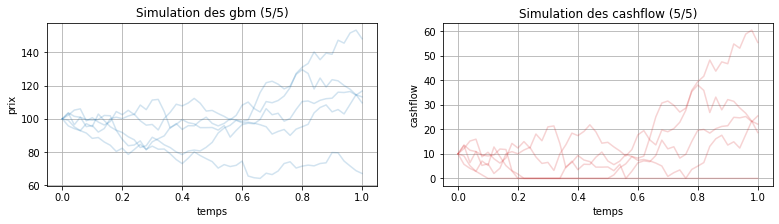

In [5]:
def phi_premier_test(X, K:float):
    return np.maximum(X - K, 0)
Y = MBG(M=5, T = 1, N = 50, rnd=rng)
fig, axs = plt.subplots(1, 2, figsize=(13, 3))
Y.simu_paths(); Y.plot_paths(ax=axs[0])
Y.simu_cashflow(phi, 90); Y.plot_cashflow(ax=axs[1])

## Dev du Pricer

In [6]:
def bermuda_pricer(x0:float=100, mu:float=0.04, r:float=0.04, sigma:float=0.1, T:float=1.0, 
                   K:float=100, phi = (lambda x, k : max(0, x-k)), m:int=3,
                   N:int=10, M:int=100000, rnd:np.random.Generator=default_rng(), verbose:bool=False) -> float:
    
    X = MBG(x0, mu, r, sigma, T, N, M, rnd) # Création de notre objet X
    X.simu_paths() # Simulation des paths (X_n(j))
    X.simu_cashflow(phi, K) # Simualation des cashflow, phi_n(X_n (j))
    
    stop_time = np.full((X.N+1, X.M), 0) #Initialisation des stopping time
    stop_time[-1, :] = X.N
    
    for n in range(N-1, 0, -1): # for n in range(N-1, -1, -1):

        # Identification du cash flow
        cashflow_n = X.cashflow[n]  # ;print(cashflow_n)
                
        # Calcul des cash flow dynamique (le Y de la regression OLS) et du X        
        X_tau = np.array( [ X.paths[tau][j] for j, tau in enumerate(stop_time[n+1])] )
        X_train_t = np.array([X_tau ** i for i in range(m+1)]) #construction matrice X pour OLS
        X_train = np.transpose(X_train_t)
        Y_train = phi(X_tau, K) * np.exp(-r * n * X.dt) #constuction matrice Y pour OLS
        X.cflow_dyn[n+1] = Y_train #on sauvergade des cash flow dynamiques
        
        # Construction du theta de la regression OLS
        try :
            theta = np.linalg.inv(X_train_t @ X_train) @ X_train_t @ Y_train
        except:
            theta = np.zeros((m+1, 1))
            theta[1 % (m+1)] = 1
            print(f"Problème dans la calculation du theta à n = {n}.")
        
        # Prediction avec OLS
        X_pred = np.transpose(np.array([X.paths[n] ** i for i in range(m+1)]))
        phi_n_pred = X_pred @ theta
        X.OLS_cashflow[n] = phi_n_pred
        
        # Mise à jour des stopping time
        stop_time[n] = n*(cashflow_n >= phi_n_pred).astype(int) + stop_time[n+1]*(cashflow_n < phi_n_pred).astype(int)
    
    # Sauvegarde des stopping time
    X.stop_time = stop_time
    
    # Determination du prix en t=0
    value = 0
    for j in range(X.M):
        tau_1_j = stop_time[1][j]
        X_1_j = X.paths[tau_1_j][j]
        value = value * (j/(j+1)) + np.exp(-r*X.dt) * phi(X_1_j, K) / (j+1)
    value = max(value, phi(X.x0, K))
    
    if verbose:
        fig, axs = plt.subplots(2, 2, figsize=(15, 9))
        X.plot_paths(ax=axs[0,0])
        #X.plot_cashflow()
        X.plot_OLS_cashflow(5, ax=axs[0,1])
        X.plot_exercise_status(5, ax=axs[1,0])
        X.plot_paths_and_exercise(ax=axs[1,1])
        
    return value


## Test du pricer pour une option simple et en petite dimension.

2.5201261106822463

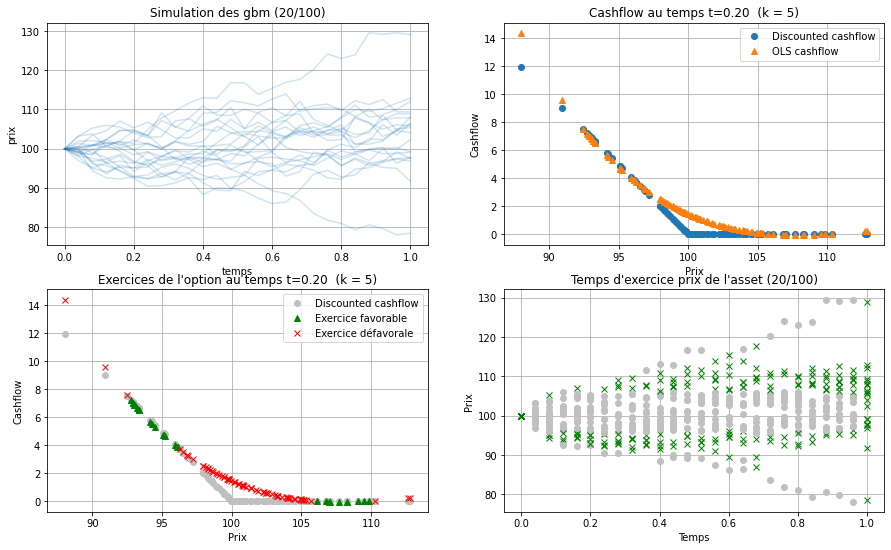

In [7]:
def phi_test_1(X, K:float):
    return np.maximum(K - X, 0)

def phi_test_2(X, K:float):
    return np.maximum(X - K, 0)

params_test = {"x0":100, 
          "mu":0.04,
          "r":0.04,
          "sigma":0.1, 
          "T":1.0, 
          "K":100, 
          "phi":phi_test_1,
          "m":3, #degré du polynome OLS
          "N":25, #nombre de periode
          "M":100, #nombre de trajectoire
          "rnd":rng, #generateur aléatoire
          "verbose":True}

bermuda_pricer(**params_test)

## Application pour l'option du mini projet

In [8]:
def put(X, K:float):
    return np.maximum(K - X, 0)

params = {"x0":100, 
          "mu":0.04,
          "r":0.04,
          "sigma":0.1, 
          "T":1.0, 
          "K":100, 
          "phi":put,
          "m":3,
          "N":10, 
          "M":10000,
          "rnd":rng,
          "verbose":False}

bermuda_pricer(**params)

2.510378639640899

**Timer du pricer**

In [9]:
print(f"Temps d'execution pour paramètres d'essai (option ATM, M = {params_test['M']}).")
params_test["verbose"] = False
%timeit bermuda_pricer(**params_test)

print("\nTemps d'execution pour paramètres du mini-projet (put ATM, M=100.000).")
%timeit bermuda_pricer(**params)

Temps d'execution pour paramètres d'essai (option ATM, M = 100).
3.38 ms ± 14.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

Temps d'execution pour paramètres du mini-projet (put ATM, M=100.000).
76.1 ms ± 667 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Vérification CRR
On reprend la fonction CRR du tp precedant et on price la meme option avec le meme nombre de periode.

In [10]:
def american_option_crr_short(opt:str, S:float, K:float, r:float, sigma:float, T:float, N:int=-1, rounded:int=4):
    if opt not in ["call", "put"] : 
        raise Exception("Invalid option name. Must be 'call' or 'put'")
    
    # Parameters
    f = lambda S, K : S - K if opt == "call" else K - S
    F = np.vectorize(f)
    N = max(N, 1 + round(T * ((r - .5 * sigma ** 2) ** 2) / (sigma ** 2)))
    dt = T / N                            
    u = np.exp(sigma * np.sqrt(dt))       
    d = 1 / u                    
    p = 0.5 * (1 + (r - 0.5 * sigma ** 2) * np.sqrt(dt) / sigma) 
    
    # Initialisation
    stock_prices = [[S * (u**(i-j)) * (d**j) for j in range(i+1)] for i in range(N+1)]
    option_values = [[0] * (i+1) for i in range(N+1)]  
    option_values[-1] = list(np.maximum(0, F(stock_prices[N], K)))
    
    # Backward propagation of CRR tree
    for i in range(N-1, -1, -1):
        for j in range(i+1):
            expected_value = np.exp(-r * dt)*(p * option_values[i+1][j] + (1-p) * option_values[i+1][j+1] )
            exercise_value = f(stock_prices[i][j], K)
            option_values[i][j] = max(expected_value, exercise_value)
    
    return round(option_values[0][0], rounded)

In [11]:
params_CRR = {"S" : 100, "K" : 100, "r" : 0.04, "sigma" : 0.1, "T" : 1, "N" : 10}
american_option_crr_short("put", **params_CRR)

2.6186

In [12]:
print("\nTemps d'execution pricer CRR.")
%timeit american_option_crr_short("put", **params_CRR)


Temps d'execution pricer CRR.
200 µs ± 11.6 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## Conclusion

On trouve une valeur similaire, dans le meme ordre de grandeur.